In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
from google.colab import data_table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az


project_id = "test-ga4-project-workshop"
client = bigquery.Client(project=project_id)

##Upload Data


In [ ]:
query = """
SELECT *
FROM `test-ga4-project-workshop.analytics_310761705.capstone_view_w2`
"""
df = client.query(query).to_dataframe()
df.head()

,user_pseudo_id,session_id,session_start_time,session_end_time,event_time,event_name,funnel_stage,customer_type,traffic_source,dominant_device_category,session_duration_sec
0,841972376.1724735322,1724735321,2024-08-27 05:08:41.742298+00:00,2024-08-27 05:09:07.035455+00:00,2024-08-27 05:08:41.743327+00:00,view_item,Product Exploration,None,google,mobile,25.293157
1,817549771.1724735549,1724735548,2024-08-27 05:12:29.841025+00:00,2024-08-27 05:12:38.156485+00:00,2024-08-27 05:12:29.841455+00:00,page_view,Awareness,None,(direct),desktop,8.315460
2,75772856.1724735596,1724735596,2024-08-27 05:13:18.316070+00:00,2024-08-27 05:13:21.951021+00:00,2024-08-27 05:13:18.317963+00:00,page_view,Awareness,None,(direct),desktop,3.634951
3,1091227127.1724735730,1724735733,2024-08-27 05:15:34.342661+00:00,2024-08-27 05:15:52.656318+00:00,2024-08-27 05:15:34.404993+00:00,view_item,Product Exploration,None,(direct),desktop,18.313657
4,255870723.1724736207,1724736207,2024-08-27 05:23:27.835690+00:00,2024-08-27 05:29:52.969564+00:00,2024-08-27 05:28:25.501772+00:00,page_view,Awareness,None,google,mobile,385.133874


In [ ]:
# Extract Hour & Weekday
df['session_hour'] = df['session_start_time'].dt.hour
df['session_weekday'] = df['session_start_time'].dt.dayofweek  # 0=Monday, 6=Sunday
df[['session_hour','session_weekday']].describe()

,session_hour,session_weekday
count,6.773286e+06,6.773286e+06
mean,1.447064e+01,2.200747e+00
std,4.969088e+00,1.585954e+00
min,0.000000e+00,0.000000e+00
25%,1.300000e+01,1.000000e+00
50%,1.500000e+01,2.000000e+00
75%,1.800000e+01,3.000000e+00
max,2.300000e+01,6.000000e+00


## Funnel KPI segmented by channel/time

In [ ]:
# Session-Level Funnel Events
funnel_df = (
    df.groupby(['user_pseudo_id', 'session_id'], as_index=False)
      .agg({
          'event_name': lambda x: set(x),
          'session_hour': 'first',
          'session_weekday': 'first',
          'customer_type': 'first',
          'traffic_source': 'first'
      })
)

# Funnel Steps
funnel_steps = ['page_view', 'view_item', 'add_to_cart','begin_checkout','add_shipping_info','add_payment_info', 'purchase']

# Label the funnel status
for step in funnel_steps:
    funnel_df[step] = funnel_df['event_name'].apply(lambda x: step in x)



In [ ]:
# Conversion Rate by session_hour
session_hour_summary = (
    funnel_df.groupby('session_hour')[funnel_steps]
             .sum()
             .astype(int)
)

session_hour_conversion = session_hour_summary.copy()
for i in range(1, len(funnel_steps)):
    prev_step = funnel_steps[i-1]
    current_step = funnel_steps[i]
    session_hour_conversion[current_step + '_rate'] = (
        session_hour_summary[current_step] / session_hour_summary[prev_step]
    ).round(3)

session_hour_conversion['overall_conversion_rate'] = (
    session_hour_summary['purchase'] / session_hour_summary['page_view']
).round(3)


session_hour_conversion

,page_view,view_item,add_to_cart,begin_checkout,add_shipping_info,add_payment_info,purchase,view_item_rate,add_to_cart_rate,begin_checkout_rate,add_shipping_info_rate,add_payment_info_rate,purchase_rate,overall_conversion_rate
session_hour,,,,,,,,,,,,,,
0,41065,19014,1096,664,443,366,339,0.463,0.058,0.606,0.667,0.826,0.926,0.008
1,37425,16343,809,470,300,242,225,0.437,0.050,0.581,0.638,0.807,0.930,0.006
2,33481,13243,700,424,281,216,196,0.396,0.053,0.606,0.663,0.769,0.907,0.006
3,34720,15237,581,354,209,150,136,0.439,0.038,0.609,0.590,0.718,0.907,0.004
4,30297,12718,451,264,154,108,96,0.420,0.035,0.585,0.583,0.701,0.889,0.003
5,29120,11075,342,194,114,77,65,0.380,0.031,0.567,0.588,0.675,0.844,0.002
6,24567,7159,313,237,118,50,35,0.291,0.044,0.757,0.498,0.424,0.700,0.001
7,26289,9800,321,235,152,49,33,0.373,0.033,0.732,0.647,0.322,0.673,0.001
8,25483,9649,321,235,161,67,48,0.379,0.033,0.732,0.685,0.416,0.716,0.002


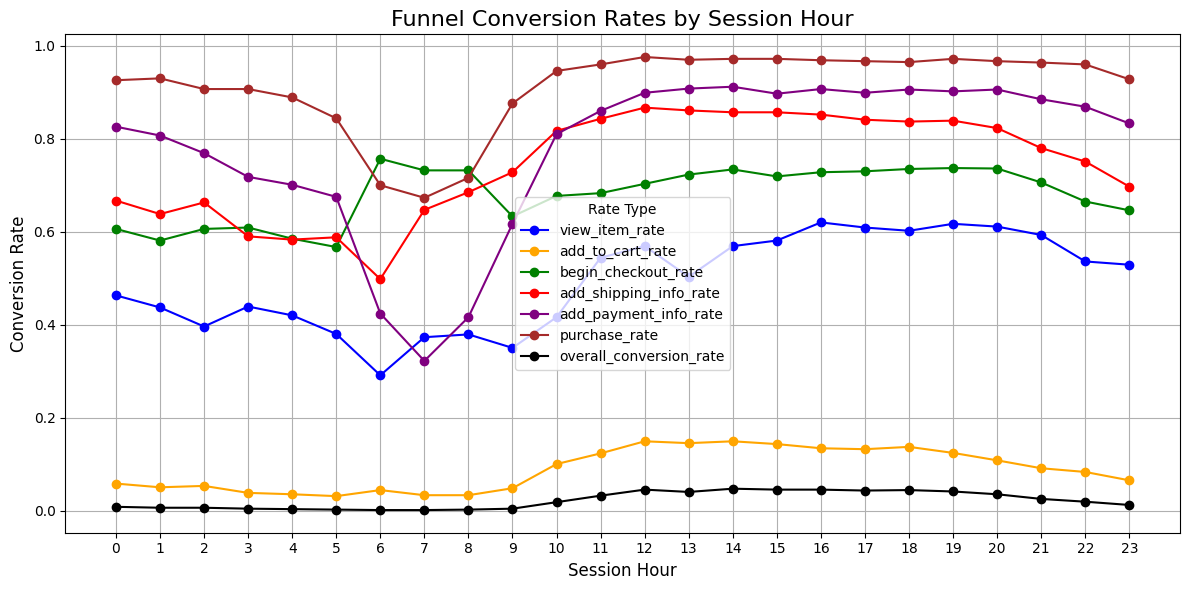

In [ ]:
# Funnel Conversion Rates by Session Hour
x = session_hour_conversion.index

# Set rates for each funnel step
rate_columns = [
    'view_item_rate',
    'add_to_cart_rate',
    'begin_checkout_rate',
    'add_shipping_info_rate',
    'add_payment_info_rate',
    'purchase_rate',
    'overall_conversion_rate'
]


colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'black']

plt.figure(figsize=(12, 6))

for rate, color in zip(rate_columns, colors):
    plt.plot(x, session_hour_conversion[rate], marker='o', label=rate, color=color)

plt.title('Funnel Conversion Rates by Session Hour', fontsize=16)
plt.xlabel('Session Hour', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Rate Type', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2053852701.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  funnel_df.groupby('hour_bin')[funnel_steps]


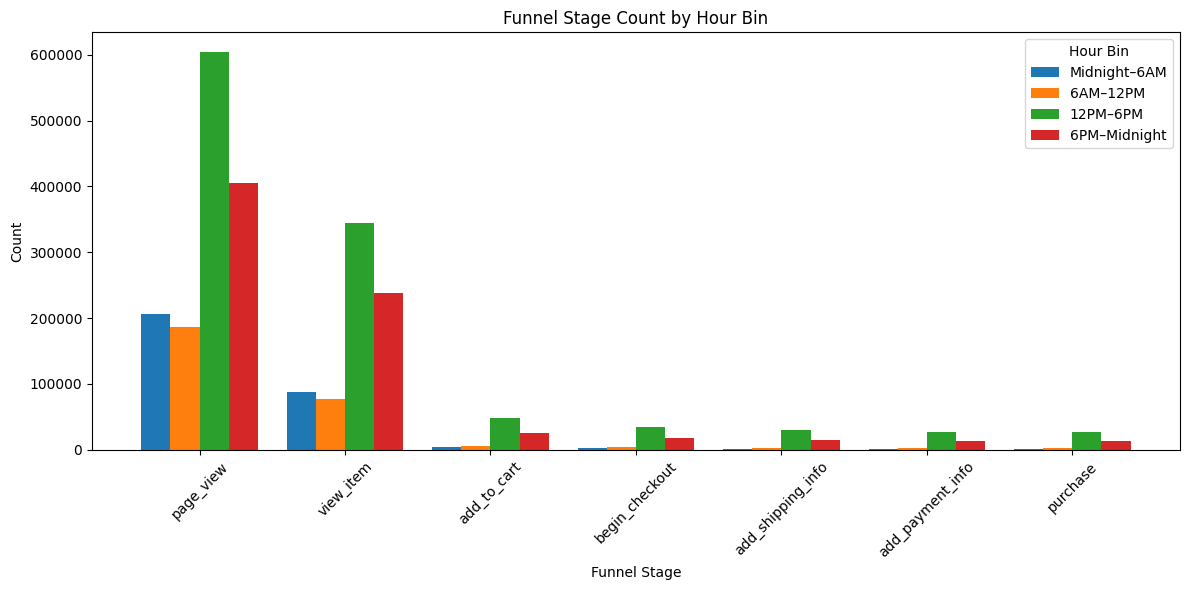

In [ ]:
# Set Hour Bins
bins = [0, 6, 12, 18, 24]
labels = ['Midnight–6AM', '6AM–12PM', '12PM–6PM', '6PM–Midnight']
funnel_df['hour_bin'] = pd.cut(funnel_df['session_hour'], bins=bins, labels=labels, right=False)

# Funnel Stage Count by Hour Bin
hour_bin_summary = (
    funnel_df.groupby('hour_bin')[funnel_steps]
             .sum()
             .astype(int)
             .reset_index()
)

plot_df = hour_bin_summary.melt(id_vars='hour_bin', var_name='funnel_stage', value_name='count')

funnel_stage_order = funnel_steps
hour_bin_order = labels
x = np.arange(len(funnel_stage_order))
width = 0.2

plt.figure(figsize=(12, 6))

for i, hour_bin in enumerate(hour_bin_order):
    subset = plot_df[plot_df['hour_bin'] == hour_bin]
    subset = subset.set_index('funnel_stage').reindex(funnel_stage_order)
    plt.bar(x + i*width, subset['count'], width=width, label=hour_bin)

plt.xticks(x + width * (len(hour_bin_order)-1) / 2, funnel_stage_order, rotation=45)
plt.xlabel('Funnel Stage')
plt.ylabel('Count')
plt.title('Funnel Stage Count by Hour Bin')
plt.legend(title='Hour Bin')
plt.tight_layout()
plt.show()

In [ ]:
# Conversion Rate Group by session_weekday
session_weekday_summary = (
    funnel_df.groupby('session_weekday')[funnel_steps]
             .sum()
             .astype(int)
)

session_weekday_conversion = session_weekday_summary.copy()
for i in range(1, len(funnel_steps)):
    prev_step = funnel_steps[i-1]
    current_step = funnel_steps[i]
    session_weekday_conversion[current_step + '_rate'] = (
        session_weekday_summary[current_step] / session_weekday_summary[prev_step]
    ).round(3)

session_weekday_conversion['overall_conversion_rate'] = (
    session_weekday_summary['purchase'] / session_weekday_summary['page_view']
).round(3)


session_weekday_conversion

,page_view,view_item,add_to_cart,begin_checkout,add_shipping_info,add_payment_info,purchase,view_item_rate,add_to_cart_rate,begin_checkout_rate,add_shipping_info_rate,add_payment_info_rate,purchase_rate,overall_conversion_rate
session_weekday,,,,,,,,,,,,,,
0,220603,121485,15632,11493,9606,8591,8320,0.551,0.129,0.735,0.836,0.894,0.968,0.038
1,274651,143777,17641,12765,10678,9510,9210,0.523,0.123,0.724,0.837,0.891,0.968,0.034
2,267521,147965,17608,12440,10400,9208,8904,0.553,0.119,0.706,0.836,0.885,0.967,0.033
3,251598,140301,16777,11782,9896,8919,8595,0.558,0.120,0.702,0.840,0.901,0.964,0.034
4,209393,117273,13362,9687,8022,7161,6922,0.560,0.114,0.725,0.828,0.893,0.967,0.033
5,93202,40396,2041,1334,899,686,636,0.433,0.051,0.654,0.674,0.763,0.927,0.007
6,84492,36714,1686,1017,687,536,497,0.435,0.046,0.603,0.676,0.780,0.927,0.006


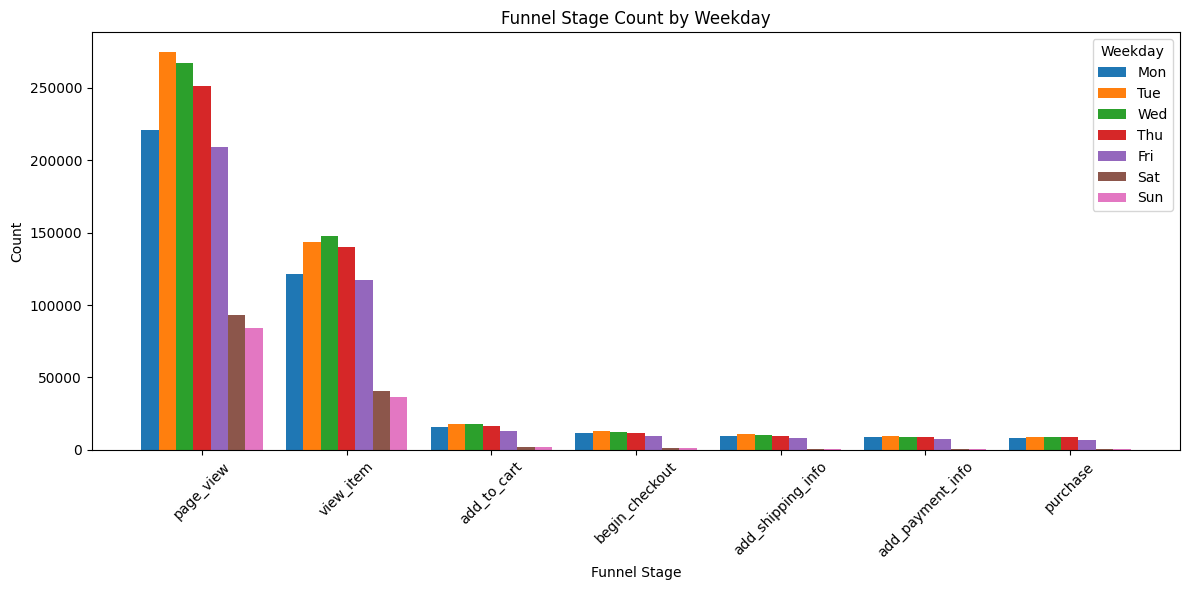

In [ ]:
#Funnel Stage Count by Weekday
# Label Weekday
session_weekday_conversion = session_weekday_conversion.sort_index()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Reset index and reshape data to long format
weekday_summary_long = (
    session_weekday_summary.reset_index()
    .melt(id_vars='session_weekday', var_name='funnel_stage', value_name='count')
)

funnel_stage_order = funnel_steps
weekday_order = list(range(7))  # 0 to 6
x = np.arange(len(funnel_stage_order))
width = 0.12

plt.figure(figsize=(12, 6))

for i, weekday in enumerate(weekday_order):
    subset = weekday_summary_long[weekday_summary_long['session_weekday'] == weekday]
    subset = subset.set_index('funnel_stage').reindex(funnel_stage_order)  # 保证funnel顺序一致
    plt.bar(x + i * width, subset['count'], width=width, label=weekday_labels[weekday])

plt.xticks(x + width * (len(weekday_order)-1)/2, funnel_stage_order, rotation=45)
plt.xlabel('Funnel Stage')
plt.ylabel('Count')
plt.title('Funnel Stage Count by Weekday')
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

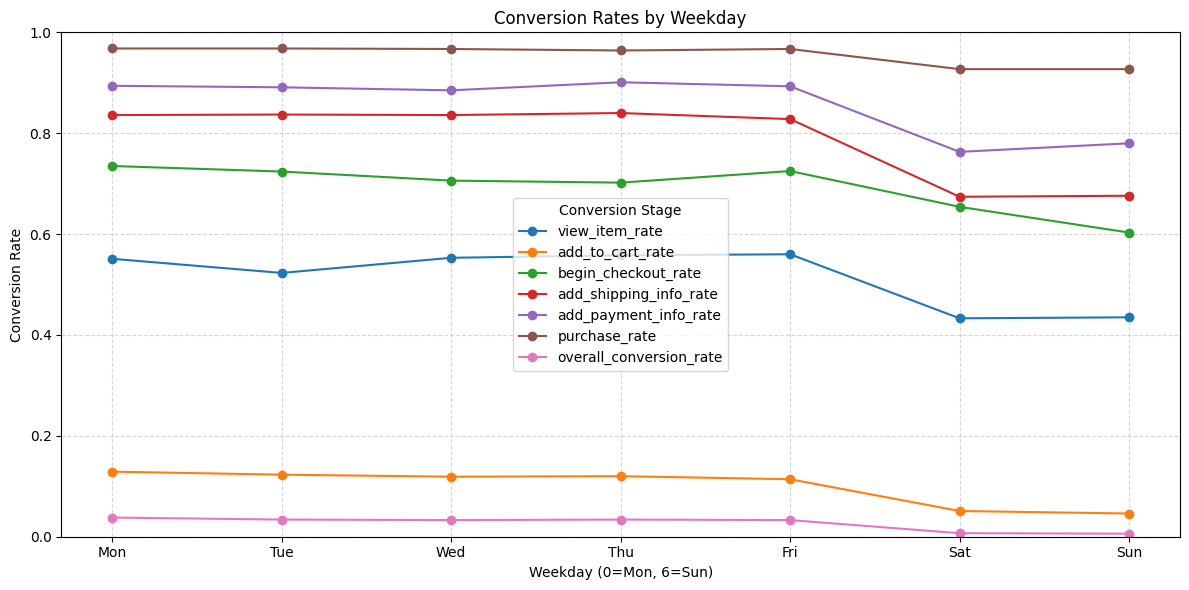

In [ ]:
#Conversion Rates by Weekday
session_weekday_conversion = session_weekday_conversion.sort_index()

rate_columns = [col for col in session_weekday_conversion.columns if col.endswith('_rate')]

plt.figure(figsize=(12, 6))

for rate_col in rate_columns:
    plt.plot(session_weekday_conversion.index, session_weekday_conversion[rate_col], marker='o', label=rate_col)

plt.title('Conversion Rates by Weekday')
plt.xlabel('Weekday (0=Mon, 6=Sun)')
plt.ylabel('Conversion Rate')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Conversion Stage')
plt.tight_layout()
plt.show()

In [ ]:
# Conversion Rate Group by customer_type
funnel_df['customer_type'] = funnel_df['customer_type'].fillna('notLoggedIn')
customer_type_summary = (
    funnel_df.groupby('customer_type')[funnel_steps]
             .sum()
             .astype(int)
)

customer_type_conversion = customer_type_summary.copy()
for i in range(1, len(funnel_steps)):
    prev_step = funnel_steps[i-1]
    current_step = funnel_steps[i]
    customer_type_conversion[current_step + '_rate'] = (
        customer_type_summary[current_step] / customer_type_summary[prev_step]
    ).round(3)

customer_type_conversion['overall_conversion_rate'] = (
    customer_type_summary['purchase'] / customer_type_summary['page_view']
).round(3)


customer_type_conversion

,page_view,view_item,add_to_cart,begin_checkout,add_shipping_info,add_payment_info,purchase,view_item_rate,add_to_cart_rate,begin_checkout_rate,add_shipping_info_rate,add_payment_info_rate,purchase_rate,overall_conversion_rate
customer_type,,,,,,,,,,,,,,
corporate,35608,25775,18891,13899,12967,12283,12200,0.724,0.733,0.736,0.933,0.947,0.993,0.343
notLoggedIn,1356637,716498,61246,40899,32022,28263,26985,0.528,0.085,0.668,0.783,0.883,0.955,0.020
web,9215,5638,4610,5720,5199,4065,3899,0.612,0.818,1.241,0.909,0.782,0.959,0.423


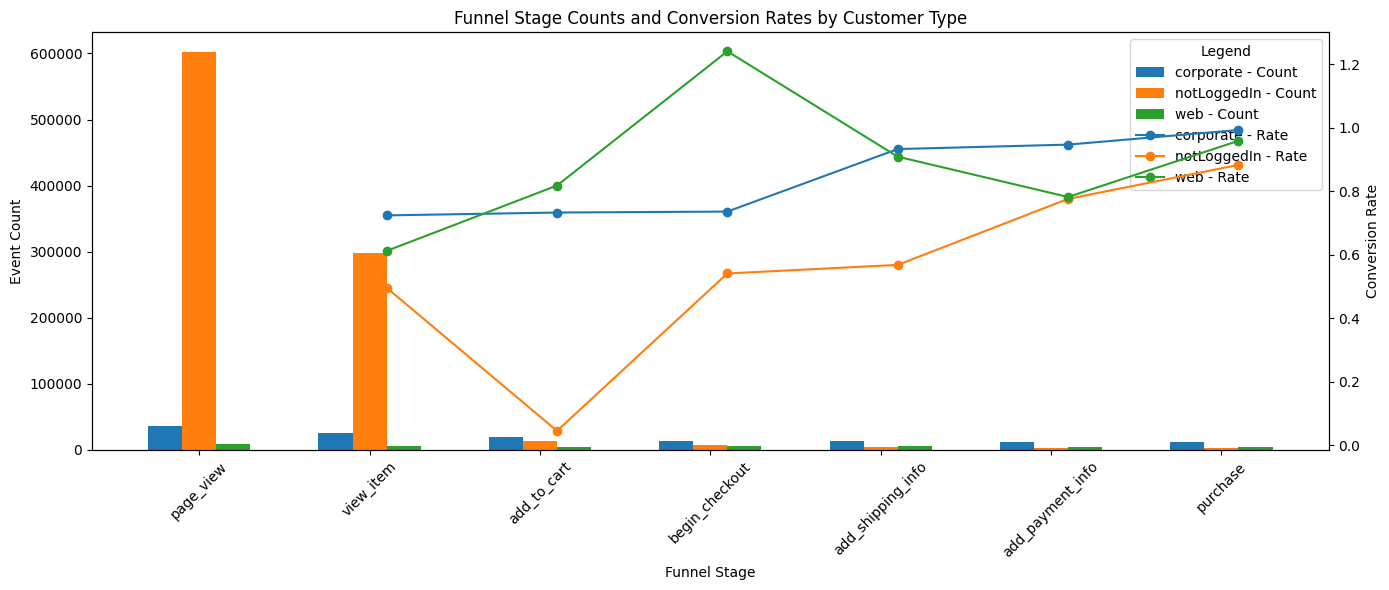

In [ ]:
#Funnel Stage Counts and Conversion Rates by Customer Type
funnel_stage_counts = customer_type_summary.reset_index()
funnel_rate = customer_type_conversion.reset_index()

funnel_stages = funnel_steps
conversion_rate_cols = ['view_item_rate', 'add_to_cart_rate', 'begin_checkout_rate',
                        'add_shipping_info_rate', 'add_payment_info_rate', 'purchase_rate']

customer_types = funnel_stage_counts['customer_type'].tolist()
x = np.arange(len(funnel_stages))
bar_width = 0.2

fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

for i, cust_type in enumerate(customer_types):
    counts = funnel_stage_counts.loc[
        funnel_stage_counts['customer_type'] == cust_type, funnel_stages
    ].values.flatten()
    ax1.bar(x + i * bar_width, counts, width=bar_width, label=f'{cust_type} - Count')

rate_x = np.arange(1, len(funnel_stages))
for i, cust_type in enumerate(customer_types):
    rates = funnel_rate.loc[
        funnel_rate['customer_type'] == cust_type, conversion_rate_cols
    ].values.flatten().astype(float)

    line_x = rate_x + (bar_width * len(customer_types) / 2)
    ax2.plot(line_x, rates, marker='o', linestyle='-', label=f'{cust_type} - Rate')

ax1.set_xlabel('Funnel Stage')
ax1.set_ylabel('Event Count')
ax2.set_ylabel('Conversion Rate')

ax1.set_xticks(x + bar_width)
ax1.set_xticklabels(funnel_stages, rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, title='Legend', loc='upper right')

plt.title('Funnel Stage Counts and Conversion Rates by Customer Type')
plt.tight_layout()
plt.show()

In [ ]:
# Conversion Rate Group by traffic_source
traffic_source_summary = (
    funnel_df.groupby('traffic_source')[funnel_steps]
             .sum()
             .astype(int)
)

traffic_source_conversion = traffic_source_summary.copy()
for i in range(1, len(funnel_steps)):
    prev_step = funnel_steps[i-1]
    current_step = funnel_steps[i]
    traffic_source_conversion[current_step + '_rate'] = (
        traffic_source_summary[current_step] / traffic_source_summary[prev_step]
    ).round(3)

traffic_source_conversion['overall_conversion_rate'] = (
    traffic_source_summary['purchase'] / traffic_source_summary['page_view']
).round(3)

# Top 5 Trffic Source
traffic_source_top5 = traffic_source_conversion.sort_values(by='page_view', ascending=False).head(6)

traffic_source_top5

,page_view,view_item,add_to_cart,begin_checkout,add_shipping_info,add_payment_info,purchase,view_item_rate,add_to_cart_rate,begin_checkout_rate,add_shipping_info_rate,add_payment_info_rate,purchase_rate,overall_conversion_rate
traffic_source,,,,,,,,,,,,,,
(direct),731353,314328,32448,27264,24000,21610,21091,0.430,0.103,0.840,0.880,0.900,0.976,0.029
google,411684,300780,30138,22416,17461,15266,14609,0.731,0.100,0.744,0.779,0.874,0.957,0.035
bing,130291,80888,10153,7433,6112,5524,5301,0.621,0.126,0.732,0.822,0.904,0.960,0.041
hs_email,57804,16344,1387,1026,877,745,709,0.283,0.085,0.740,0.855,0.849,0.952,0.012
PRODUCTAD,19482,4135,66,41,27,19,18,0.212,0.016,0.621,0.659,0.704,0.947,0.001
CJ,6575,4356,795,574,436,354,323,0.663,0.183,0.722,0.760,0.812,0.912,0.049


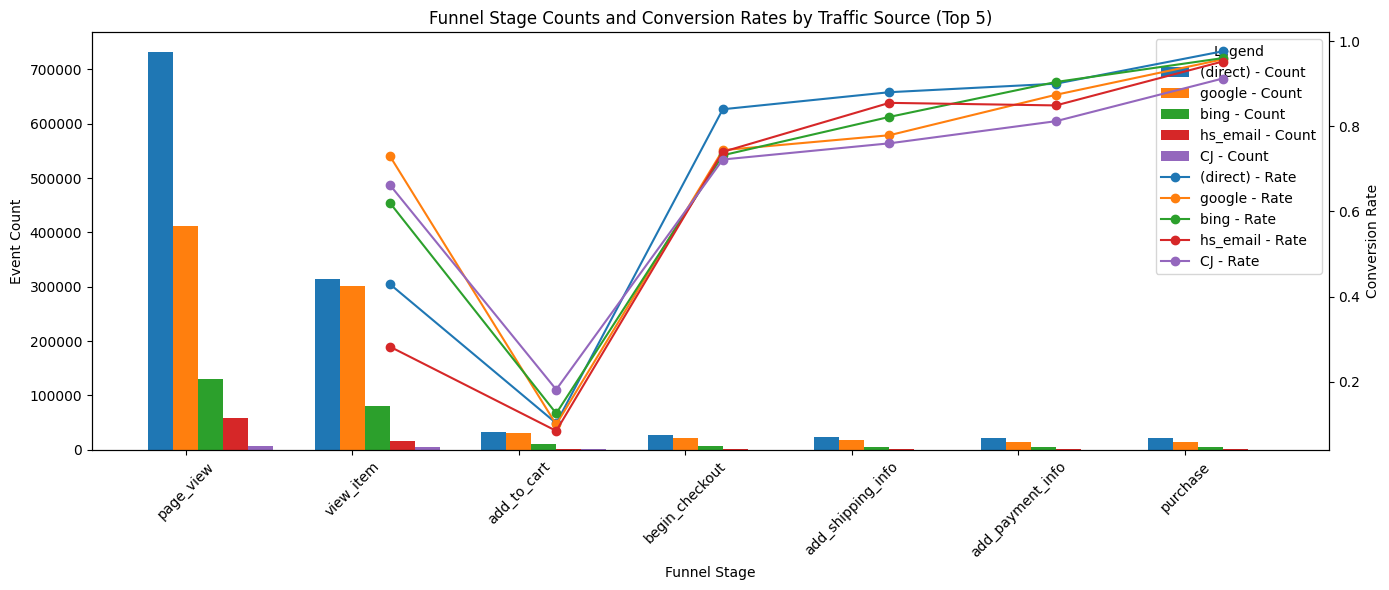

In [ ]:
#Funnel Stage Counts and Conversion Rates by Traffic Source (Top 5)

funnel_stage_counts = traffic_source_top5[funnel_steps].reset_index()
funnel_rate = traffic_source_top5.reset_index()

funnel_stages = funnel_steps
traffic_sources = funnel_stage_counts['traffic_source'].tolist()

x = np.arange(len(funnel_stages))
bar_width = 0.15


fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Histogram
for i, source in enumerate(traffic_sources):
    counts = funnel_stage_counts.loc[funnel_stage_counts['traffic_source'] == source, funnel_stages].values.flatten()
    ax1.bar(x + i * bar_width, counts, width=bar_width, label=f'{source} - Count')

# Trend
for i, source in enumerate(traffic_sources):
    rates = funnel_rate.loc[funnel_rate['traffic_source'] == source,
                            [col for col in funnel_rate.columns if col.endswith('_rate') and col != 'overall_conversion_rate']
                           ].values.flatten().astype(float)


    line_x = x[1:] + (bar_width * len(traffic_sources) / 2)
    ax2.plot(line_x, rates, marker='o', linestyle='-', label=f'{source} - Rate')

ax1.set_xlabel('Funnel Stage')
ax1.set_ylabel('Event Count')
ax2.set_ylabel('Conversion Rate')

ax1.set_xticks(x + bar_width)
ax1.set_xticklabels(funnel_stages, rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, title='Legend', loc='upper right')

plt.title('Funnel Stage Counts and Conversion Rates by Traffic Source (Top 5)')
plt.tight_layout()
plt.show()

In [ ]:
#Conversion Rate by Hour & Weekday

funnel_df['hour_weekday'] = funnel_df['session_weekday'].astype(str) + '-' + funnel_df['session_hour'].astype(str)
summary_hw = (
    funnel_df.groupby('hour_weekday')[funnel_steps]
             .sum()
             .astype(int)
)

conversion_hw = summary_hw.copy()
for i in range(1, len(funnel_steps)):
    prev_step = funnel_steps[i-1]
    current_step = funnel_steps[i]
    conversion_hw[current_step + '_rate'] = (
        summary_hw[current_step] / summary_hw[prev_step]
    ).round(3)

conversion_hw['overall_conversion_rate'] = (
    summary_hw['purchase'] / summary_hw['page_view']
).round(3)

conversion_hw = conversion_hw.reset_index()
conversion_hw[['weekday', 'hour']] = conversion_hw['hour_weekday'].str.split('-', expand=True).astype(int)

conversion_hw.sort_values(by='page_view', ascending=False).head(1000)

,hour_weekday,page_view,view_item,add_to_cart,begin_checkout,add_shipping_info,add_payment_info,purchase,view_item_rate,add_to_cart_rate,begin_checkout_rate,add_shipping_info_rate,add_payment_info_rate,purchase_rate,overall_conversion_rate,weekday,hour
29,1-13,33717,14613,2022,1504,1313,1204,1174,0.433,0.138,0.744,0.873,0.917,0.975,0.035,1,13
53,2-13,30854,15203,1935,1355,1192,1058,1026,0.493,0.127,0.700,0.880,0.888,0.970,0.033,2,13
30,1-14,29479,13781,2045,1533,1306,1204,1175,0.467,0.148,0.750,0.852,0.922,0.976,0.040,1,14
54,2-14,25860,15264,2045,1493,1266,1160,1128,0.590,0.134,0.730,0.848,0.916,0.972,0.044,2,14
79,3-15,23622,12049,1790,1287,1132,1022,994,0.510,0.149,0.719,0.880,0.903,0.973,0.042,3,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,5-22,3009,1207,80,52,30,28,27,0.401,0.066,0.650,0.577,0.933,0.964,0.009,5,22
122,5-10,2989,1052,46,26,20,15,11,0.352,0.044,0.565,0.769,0.750,0.733,0.004,5,10
167,6-9,2989,1095,19,9,4,4,1,0.366,0.017,0.474,0.444,1.000,0.250,0.000,6,9
164,6-6,2926,784,27,12,5,4,3,0.268,0.034,0.444,0.417,0.800,0.750,0.001,6,6


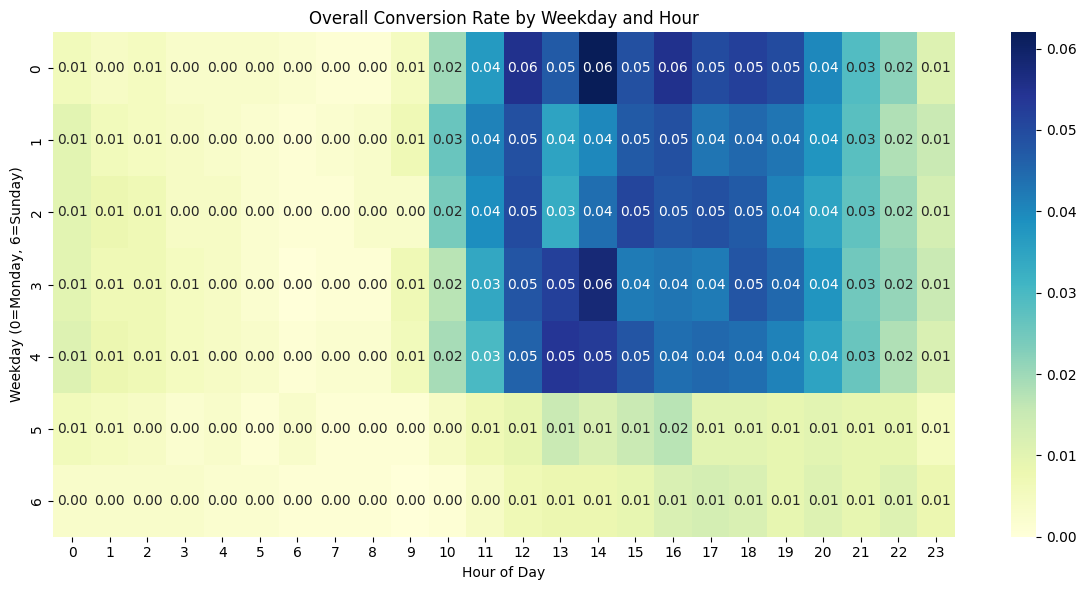

In [ ]:
# Overall Conversion Rate by Weekday and Hour
pivot_table = conversion_hw.pivot(index='weekday', columns='hour', values='overall_conversion_rate')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Overall Conversion Rate by Weekday and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday (0=Monday, 6=Sunday)')
plt.tight_layout()
plt.show()

In [ ]:
# Overall Conversion Rate by Traffic Source and Customer Type
top_sources = (
    funnel_df.groupby('traffic_source')['page_view']
    .sum()
    .sort_values(ascending=False)
    .head(6)
    .index.tolist()
)

funnel_df['traffic_group'] = funnel_df['traffic_source'].apply(
    lambda x: x if x in top_sources else 'Other'
)

grouped = (
    funnel_df.groupby(['customer_type', 'traffic_group'])[funnel_steps]
    .sum()
    .astype(int)
    .reset_index()
)

conversion = grouped.copy()

for i in range(1, len(funnel_steps)):
    prev = funnel_steps[i-1]
    curr = funnel_steps[i]
    conversion[curr + '_rate'] = (conversion[curr] / conversion[prev]).round(3)

conversion['overall_conversion_rate'] = (
    conversion['purchase'] / conversion['page_view']
).round(3)


conversion

,customer_type,traffic_group,page_view,view_item,add_to_cart,begin_checkout,add_shipping_info,add_payment_info,purchase,view_item_rate,add_to_cart_rate,begin_checkout_rate,add_shipping_info_rate,add_payment_info_rate,purchase_rate,overall_conversion_rate
0,corporate,(direct),17812,12351,9073,8048,7421,7094,7052,0.693,0.735,0.887,0.922,0.956,0.994,0.396
1,corporate,CJ,137,110,71,64,61,44,44,0.803,0.645,0.901,0.953,0.721,1.000,0.321
2,corporate,Other,7458,5446,4008,340,292,274,265,0.730,0.736,0.085,0.859,0.938,0.967,0.036
3,corporate,PRODUCTAD,10,8,5,5,4,4,4,0.800,0.625,1.000,0.800,1.000,1.000,0.400
4,corporate,bing,3025,2379,1659,1520,1439,1353,1350,0.786,0.697,0.916,0.947,0.940,0.998,0.446
5,corporate,google,6932,5296,3935,3797,3632,3400,3372,0.764,0.743,0.965,0.957,0.936,0.992,0.486
6,corporate,hs_email,234,185,140,125,118,114,113,0.791,0.757,0.893,0.944,0.966,0.991,0.483
7,notLoggedIn,(direct),357183,135844,2707,1392,838,673,568,0.380,0.020,0.514,0.602,0.803,0.844,0.002
8,notLoggedIn,CJ,1984,1416,183,106,59,41,33,0.714,0.129,0.579,0.557,0.695,0.805,0.017
9,notLoggedIn,Other,11084,5839,456,288,162,117,101,0.527,0.078,0.632,0.562,0.722,0.863,0.009


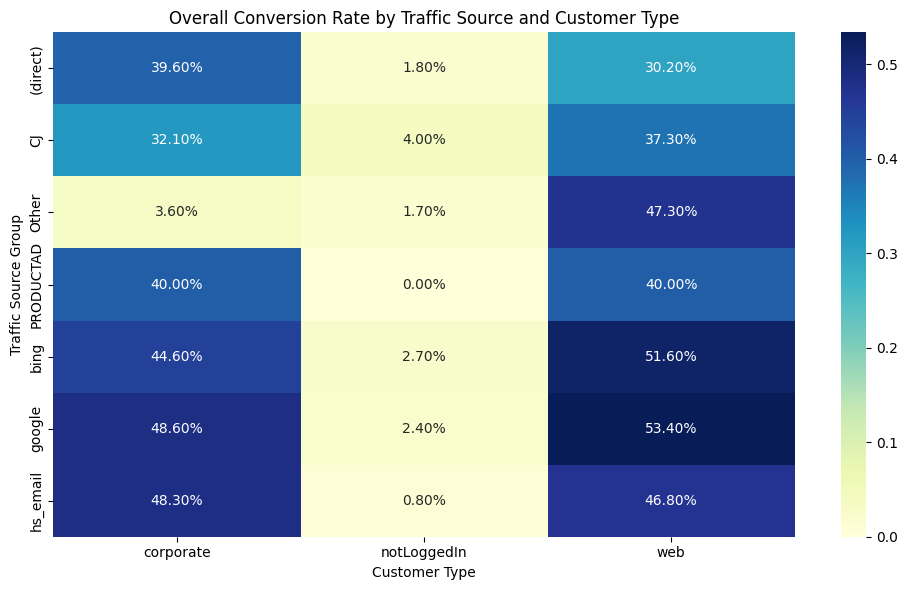

In [ ]:
#Overall Conversion Rate by Traffic Source and Customer Type
pivot_table = conversion.pivot(index='traffic_group', columns='customer_type', values='overall_conversion_rate')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='YlGnBu')
plt.title('Overall Conversion Rate by Traffic Source and Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Traffic Source Group')
plt.tight_layout()
plt.show()

## Bayesian Funnel Benchmark Model

### Bayesian Funnel Benchmark Model (view_item → add_to_cart)





In [ ]:
# Bayesian Funnel Benchmark Model by Hourbin+ Weekday

funnel_df['hourbin_weekday'] = funnel_df['session_weekday'].astype(str) + '-' + funnel_df['hour_bin'].astype(str)
summary_hbw = (
    funnel_df.groupby('hourbin_weekday')[funnel_steps]
             .sum()
             .astype(int)

)
conversion_hbw = summary_hbw.copy()
for i in range(1, len(funnel_steps)):
    prev_step = funnel_steps[i-1]
    current_step = funnel_steps[i]
    conversion_hbw[current_step + '_rate'] = (
        summary_hbw[current_step] / summary_hbw[prev_step]
    ).round(3)

conversion_hbw['overall_conversion_rate'] = (
    summary_hbw['purchase'] / summary_hbw['page_view']
).round(3)



In [ ]:
model_df = conversion_hbw.reset_index()[['hourbin_weekday', 'view_item', 'add_to_cart']].copy()
model_df.rename(columns={
    'hourbin_weekday': 'group',
    'view_item': 'n_trials',
    'add_to_cart': 'n_successes'
}, inplace=True)
model_df = model_df[model_df['n_trials'] > 0]

Output()

                    group  observed_rate   mean  hdi_2.5%  hdi_97.5%  flagged
theta[0]       0-12PM–6PM       0.165423  0.165     0.156      0.173    False
theta[1]       0-6AM–12PM       0.073879  0.074     0.063      0.085    False
theta[26]  6-6PM–Midnight       0.031975  0.033     0.024      0.041    False
theta[25]      6-6AM–12PM       0.011775  0.013     0.007      0.019    False
theta[24]      6-12PM–6PM       0.034188  0.035     0.027      0.044    False
theta[23]  5-Midnight–6AM       0.026070  0.027     0.018      0.035    False
theta[22]  5-6PM–Midnight       0.032419  0.033     0.024      0.043    False
theta[21]      5-6AM–12PM       0.017908  0.019     0.012      0.027    False
theta[20]      5-12PM–6PM       0.046768  0.047     0.037      0.059    False
theta[19]  4-Midnight–6AM       0.027929  0.029     0.020      0.037    False
theta[18]  4-6PM–Midnight       0.111520  0.111     0.100      0.123    False
theta[17]      4-6AM–12PM       0.076394  0.076     0.063      0

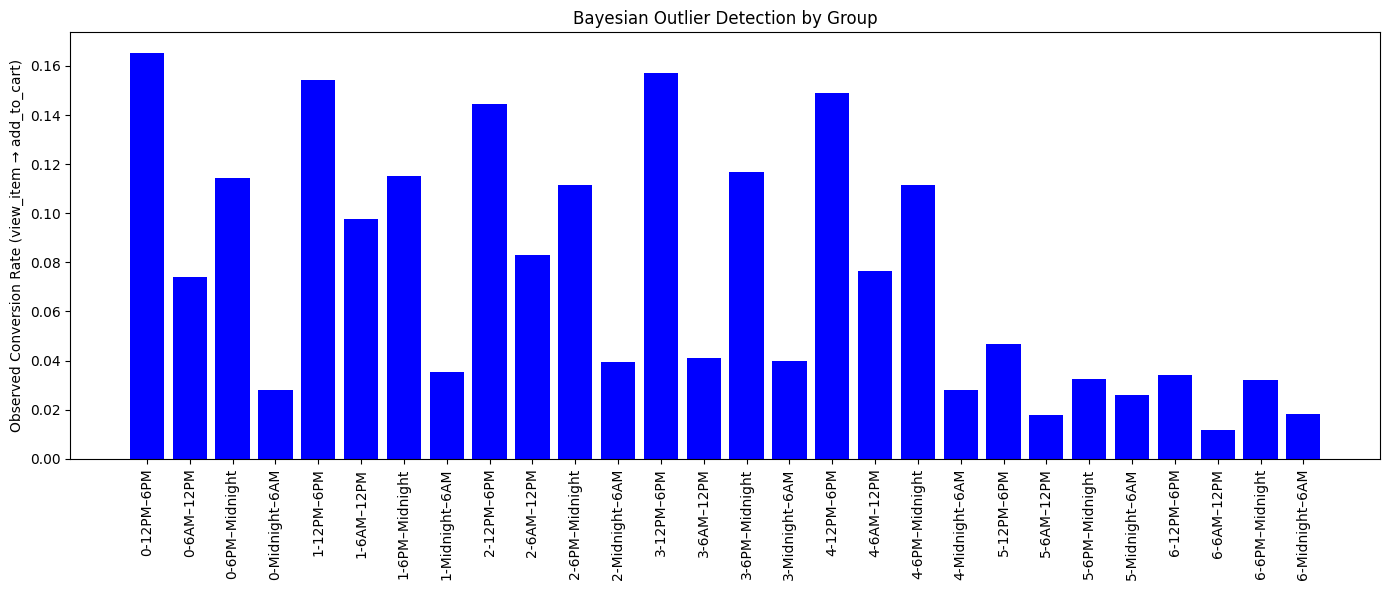

In [ ]:
# Prepare model input data
groups = model_df['group'].values              # Group labels
n_groups = len(groups)                         # Number of groups
n_trials = model_df['n_trials'].values         # Number of total trials per group
n_successes = model_df['n_successes'].values   # Number of successes per group

with pm.Model() as model:
    # Hyperpriors for the Beta distribution
    alpha_hyper = pm.HalfNormal('alpha_hyper', sigma=10)
    beta_hyper = pm.HalfNormal('beta_hyper', sigma=10)

    # Conversion rates for each group
    theta = pm.Beta('theta', alpha=alpha_hyper, beta=beta_hyper, shape=n_groups)

    # Observed data following Binomial distribution
    obs = pm.Binomial('obs', n=n_trials, p=theta, observed=n_successes)

    # Posterior sampling using MCMC
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Extract posterior summaries (mean and 95% HDI)
summary = az.summary(trace, var_names=['theta'], hdi_prob=0.95)
summary['group'] = groups
summary['observed_rate'] = n_successes / n_trials

# Flag groups where observed rate is outside 95% HDI interval
summary['flagged'] = ~summary.apply(
    lambda row: row['hdi_2.5%'] <= row['observed_rate'] <= row['hdi_97.5%'],
    axis=1
)

# Select key columns for review
summary_df = summary[['group', 'observed_rate', 'mean', 'hdi_2.5%', 'hdi_97.5%', 'flagged']].copy()

# Display flagged outliers
print(summary_df.sort_values('flagged', ascending=False))

# Visualize: red bars = outliers, blue bars = normal
plt.figure(figsize=(14, 6))
colors = summary_df['flagged'].map({True: 'red', False: 'blue'})
plt.bar(summary_df['group'], summary_df['observed_rate'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Observed Conversion Rate (view_item → add_to_cart)')
plt.title('Bayesian Outlier Detection by Group')
plt.tight_layout()
plt.show()

Output()

                           group  observed_rate   mean  hdi_2.5%  hdi_97.5%  \
theta[0]      corporate-(direct)       0.751692  0.751     0.736      0.768   
theta[1]         corporate-Other       0.761146  0.761     0.737      0.784   
theta[16]             web-google       0.840367  0.839     0.808      0.871   
theta[15]               web-bing       0.855721  0.853     0.802      0.900   
theta[14]          web-PRODUCTAD       0.750000  0.671     0.332      0.984   
theta[13]              web-Other       0.866667  0.852     0.756      0.945   
theta[12]           web-(direct)       0.814910  0.813     0.774      0.852   
theta[11]   notLoggedIn-hs_email       0.048266  0.049     0.038      0.059   
theta[10]     notLoggedIn-google       0.071694  0.072     0.068      0.075   
theta[9]        notLoggedIn-bing       0.073339  0.073     0.067      0.080   
theta[8]   notLoggedIn-PRODUCTAD       0.011719  0.013     0.005      0.020   
theta[7]       notLoggedIn-Other       0.092702  0.0

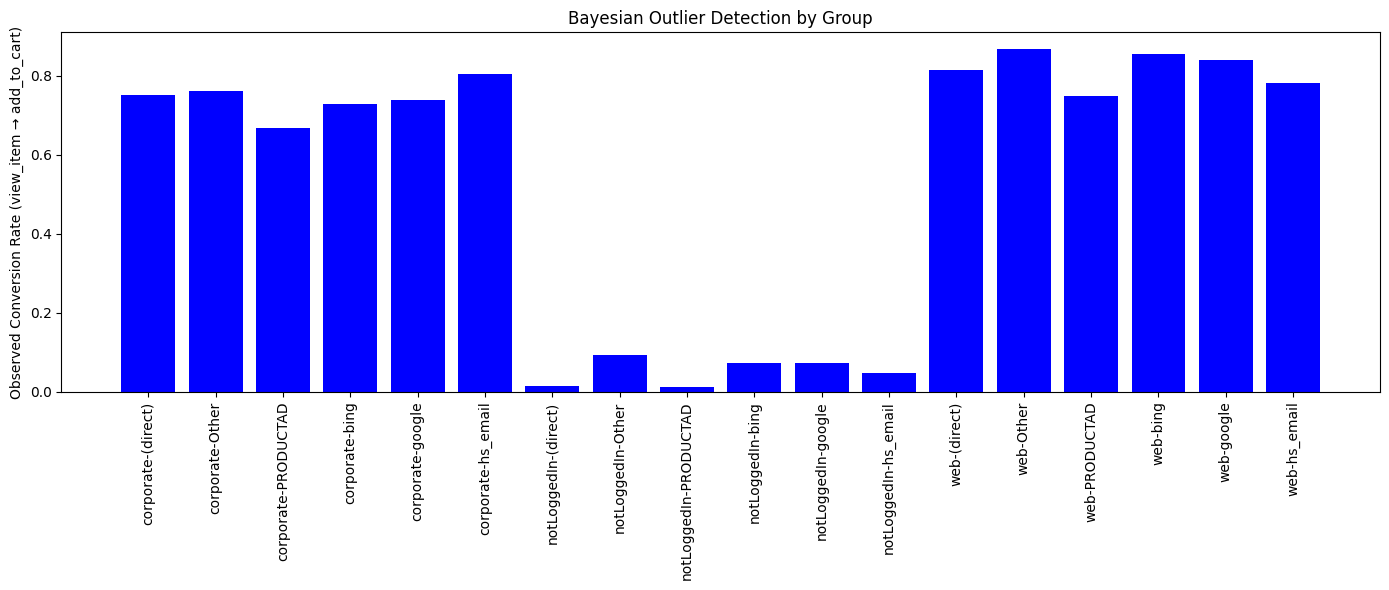

In [ ]:
# Bayesian Funnel Benchmark Model by Customer_type & Traffic_group

model_df_tc = conversion[['customer_type', 'traffic_group', 'view_item', 'add_to_cart']].copy()
model_df_tc['group'] = model_df_tc['customer_type'] + '-' + model_df_tc['traffic_group']

model_df_tc = model_df_tc.rename(columns={
    'view_item': 'n_trials',
    'add_to_cart': 'n_successes'
})


# Prepare input data for the model
groups = model_df_tc['group'].values               # Group labels
n_groups = len(groups)                             # Total number of groups
n_trials = model_df_tc['n_trials'].values          # Total trials per group
n_successes = model_df_tc['n_successes'].values    # Successful outcomes per group

with pm.Model() as model:
    # Hyperpriors for the Beta distribution parameters
    alpha_hyper = pm.HalfNormal('alpha_hyper', sigma=10)
    beta_hyper = pm.HalfNormal('beta_hyper', sigma=10)

    # Latent conversion rates for each group
    theta = pm.Beta('theta', alpha=alpha_hyper, beta=beta_hyper, shape=n_groups)

    # Observed data modeled as Binomial distribution
    obs = pm.Binomial('obs', n=n_trials, p=theta, observed=n_successes)

    # Posterior sampling using NUTS (No-U-Turn Sampler)
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Extract posterior summary statistics
summary = az.summary(trace, var_names=['theta'], hdi_prob=0.95)
summary['group'] = groups
summary['observed_rate'] = n_successes / n_trials

# Flag groups where the observed rate falls outside the 95% HDI
summary['flagged'] = ~summary.apply(
    lambda row: row['hdi_2.5%'] <= row['observed_rate'] <= row['hdi_97.5%'],
    axis=1
)

# Keep only relevant columns
summary_df = summary[['group', 'observed_rate', 'mean', 'hdi_2.5%', 'hdi_97.5%', 'flagged']].copy()

# Print top flagged rows for review
print(summary_df.sort_values('flagged', ascending=False))

# Plot observed rates with color-coded flags
plt.figure(figsize=(14, 6))
colors = summary_df['flagged'].map({True: 'red', False: 'blue'})
plt.bar(summary_df['group'], summary_df['observed_rate'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Observed Conversion Rate (view_item → add_to_cart)')
plt.title('Bayesian Outlier Detection by Group')
plt.tight_layout()
plt.show()

### Bayesian Funnel Benchmark Model (add_shipping_info -> add_payment_info)

Output()

                    group  observed_rate   mean  hdi_2.5%  hdi_97.5%  flagged
theta[0]       0-12PM–6PM       0.165423  0.165     0.156      0.174    False
theta[1]       0-6AM–12PM       0.073879  0.074     0.063      0.085    False
theta[26]  6-6PM–Midnight       0.031975  0.033     0.024      0.041    False
theta[25]      6-6AM–12PM       0.011775  0.013     0.007      0.019    False
theta[24]      6-12PM–6PM       0.034188  0.035     0.026      0.043    False
theta[23]  5-Midnight–6AM       0.026070  0.027     0.019      0.035    False
theta[22]  5-6PM–Midnight       0.032419  0.033     0.024      0.044    False
theta[21]      5-6AM–12PM       0.017908  0.019     0.011      0.027    False
theta[20]      5-12PM–6PM       0.046768  0.047     0.036      0.058    False
theta[19]  4-Midnight–6AM       0.027929  0.029     0.020      0.037    False
theta[18]  4-6PM–Midnight       0.111520  0.111     0.100      0.122    False
theta[17]      4-6AM–12PM       0.076394  0.076     0.063      0

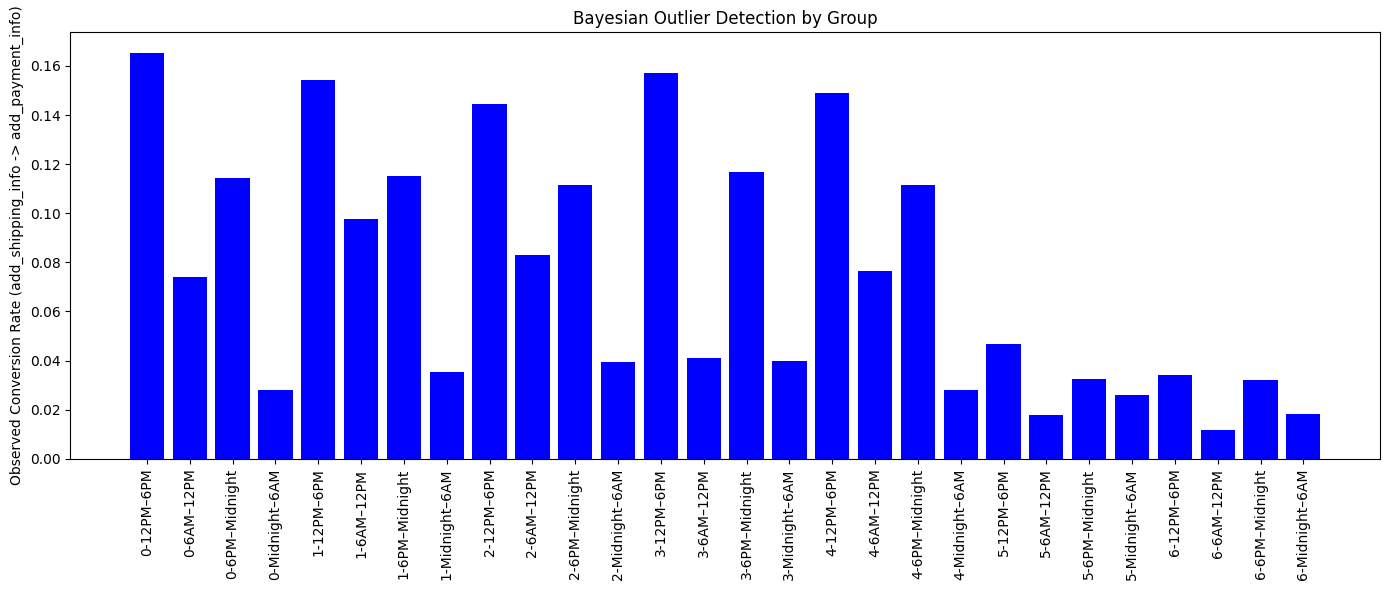

In [ ]:
# Bayesian Funnel Benchmark Model by Hourbin+ Weekday

model_df_s = conversion_hbw.reset_index()[['hourbin_weekday', 'add_shipping_info','add_payment_info']].copy()
model_df_s.rename(columns={
    'hourbin_weekday': 'group',
    'add_shipping_info': 'n_trials',
    'add_payment_info': 'n_successes'
}, inplace=True)
model_df_s = model_df[model_df['n_trials'] > 0]

# Prepare model input data
groups = model_df_s['group'].values               # Group labels
n_groups = len(groups)                            # Number of unique groups
n_trials = model_df_s['n_trials'].values          # Total number of trials (e.g., add_shipping_info events)
n_successes = model_df_s['n_successes'].values    # Number of successes (e.g., add_payment_info events)

with pm.Model() as model:
    # Hyperpriors for the Beta distribution (shared across groups)
    alpha_hyper = pm.HalfNormal('alpha_hyper', sigma=10)
    beta_hyper = pm.HalfNormal('beta_hyper', sigma=10)

    # Latent conversion rates for each group
    theta = pm.Beta('theta', alpha=alpha_hyper, beta=beta_hyper, shape=n_groups)

    # Likelihood: observed data modeled as Binomial draws
    obs = pm.Binomial('obs', n=n_trials, p=theta, observed=n_successes)

    # Sample from the posterior using NUTS
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Extract posterior summary statistics
summary = az.summary(trace, var_names=['theta'], hdi_prob=0.95)
summary['group'] = groups
summary['observed_rate'] = n_successes / n_trials

# Flag groups where observed rate falls outside the 95% HDI
summary['flagged'] = ~summary.apply(
    lambda row: row['hdi_2.5%'] <= row['observed_rate'] <= row['hdi_97.5%'],
    axis=1
)

# Keep only relevant columns for interpretation
summary_df = summary[['group', 'observed_rate', 'mean', 'hdi_2.5%', 'hdi_97.5%', 'flagged']].copy()

# Display top flagged groups (potential outliers)
print(summary_df.sort_values('flagged', ascending=False))

# Visualize observed conversion rates, coloring outliers in red
plt.figure(figsize=(14, 6))
colors = summary_df['flagged'].map({True: 'red', False: 'blue'})
plt.bar(summary_df['group'], summary_df['observed_rate'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Observed Conversion Rate (add_shipping_info → add_payment_info)')
plt.title('Bayesian Outlier Detection by Group')
plt.tight_layout()
plt.show()

Output()

                           group  observed_rate   mean  hdi_2.5%  hdi_97.5%  \
theta[0]      corporate-(direct)       0.751692  0.752     0.737      0.768   
theta[1]         corporate-Other       0.761146  0.761     0.738      0.784   
theta[16]             web-google       0.840367  0.839     0.809      0.869   
theta[15]               web-bing       0.855721  0.853     0.803      0.899   
theta[14]          web-PRODUCTAD       0.750000  0.669     0.336      0.995   
theta[13]              web-Other       0.866667  0.852     0.751      0.946   
theta[12]           web-(direct)       0.814910  0.813     0.774      0.850   
theta[11]   notLoggedIn-hs_email       0.048266  0.049     0.038      0.060   
theta[10]     notLoggedIn-google       0.071694  0.072     0.068      0.075   
theta[9]        notLoggedIn-bing       0.073339  0.073     0.067      0.080   
theta[8]   notLoggedIn-PRODUCTAD       0.011719  0.013     0.006      0.021   
theta[7]       notLoggedIn-Other       0.092702  0.0

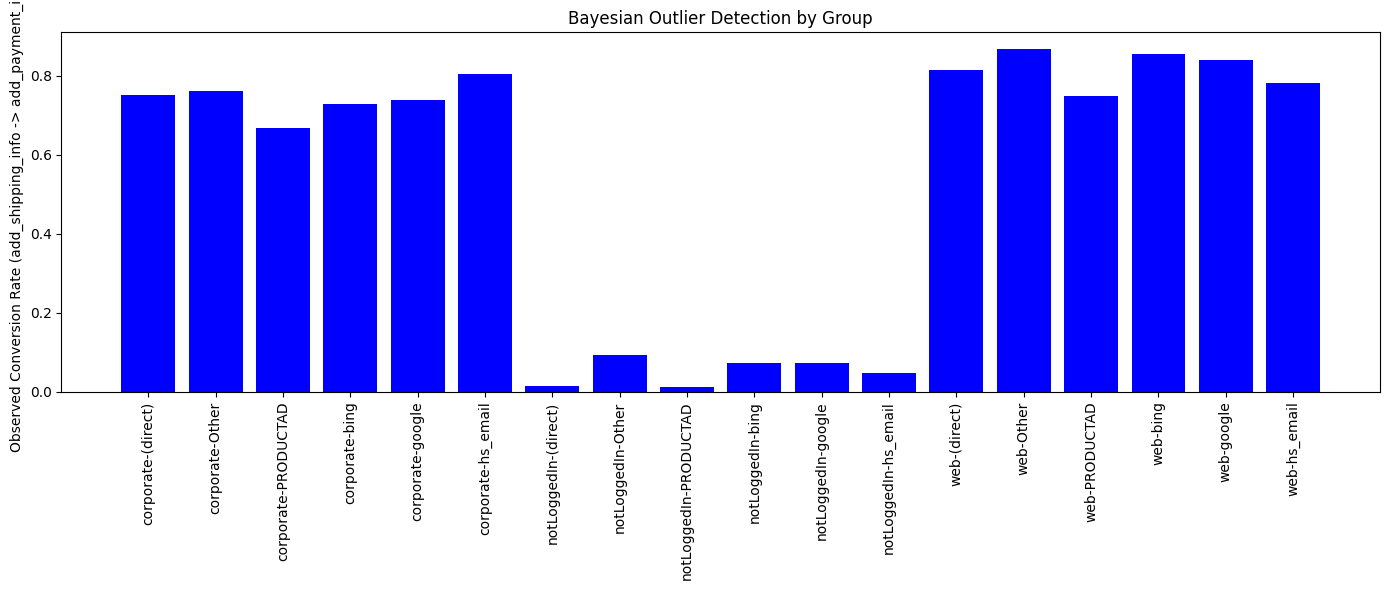

In [ ]:
# Bayesian Funnel Benchmark Model by Customer_Type + Traffic Source
model_df_tc_s = conversion[['customer_type', 'traffic_group', 'add_shipping_info','add_payment_info']].copy()
model_df_tc_s['group'] = model_df_tc['customer_type'] + '-' + model_df_tc['traffic_group']

model_df_tc_s = model_df_tc.rename(columns={
    'add_shipping_info': 'n_trials',
    'add_payment_info': 'n_successes'
})

# Prepare model input data
groups = model_df_s['group'].values               # Group labels
n_groups = len(groups)                            # Number of unique groups
n_trials = model_df_s['n_trials'].values          # Total number of trials (e.g., add_shipping_info events)
n_successes = model_df_s['n_successes'].values    # Number of successes (e.g., add_payment_info events)

with pm.Model() as model:
    # Hyperpriors for the Beta distribution (shared across groups)
    alpha_hyper = pm.HalfNormal('alpha_hyper', sigma=10)
    beta_hyper = pm.HalfNormal('beta_hyper', sigma=10)

    # Latent conversion rates for each group
    theta = pm.Beta('theta', alpha=alpha_hyper, beta=beta_hyper, shape=n_groups)

    # Likelihood: observed data modeled as Binomial draws
    obs = pm.Binomial('obs', n=n_trials, p=theta, observed=n_successes)

    # Sample from the posterior using NUTS
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Extract posterior summary statistics
summary = az.summary(trace, var_names=['theta'], hdi_prob=0.95)
summary['group'] = groups
summary['observed_rate'] = n_successes / n_trials

# Flag groups where observed rate falls outside the 95% HDI
summary['flagged'] = ~summary.apply(
    lambda row: row['hdi_2.5%'] <= row['observed_rate'] <= row['hdi_97.5%'],
    axis=1
)

# Keep only relevant columns for interpretation
summary_df = summary[['group', 'observed_rate', 'mean', 'hdi_2.5%', 'hdi_97.5%', 'flagged']].copy()

# Display top flagged groups (potential outliers)
print(summary_df.sort_values('flagged', ascending=False))

# Visualize observed conversion rates, coloring outliers in red
plt.figure(figsize=(14, 6))
colors = summary_df['flagged'].map({True: 'red', False: 'blue'})
plt.bar(summary_df['group'], summary_df['observed_rate'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Observed Conversion Rate (add_shipping_info → add_payment_info)')
plt.title('Bayesian Outlier Detection by Group')
plt.tight_layout()
plt.show()

### Bayesian Funnel Benchmark Model (begin_checkout -> purchase)

Output()

                    group  observed_rate   mean  hdi_2.5%  hdi_97.5%  flagged
theta[0]       0-12PM–6PM       0.789024  0.787     0.760      0.816    False
theta[1]       0-6AM–12PM       0.758621  0.743     0.656      0.823    False
theta[26]  6-6PM–Midnight       0.703704  0.681     0.539      0.827    False
theta[25]      6-6AM–12PM       0.285714  0.504     0.278      0.727    False
theta[24]      6-12PM–6PM       0.523810  0.549     0.421      0.686    False
theta[23]  5-Midnight–6AM       0.500000  0.544     0.379      0.704    False
theta[22]  5-6PM–Midnight       0.461538  0.516     0.348      0.666    False
theta[21]      5-6AM–12PM       0.214286  0.405     0.209      0.615    False
theta[20]      5-12PM–6PM       0.541667  0.559     0.436      0.678    False
theta[19]  4-Midnight–6AM       0.434783  0.503     0.331      0.661    False
theta[18]  4-6PM–Midnight       0.767544  0.761     0.708      0.817    False
theta[17]      4-6AM–12PM       0.692308  0.684     0.592      0

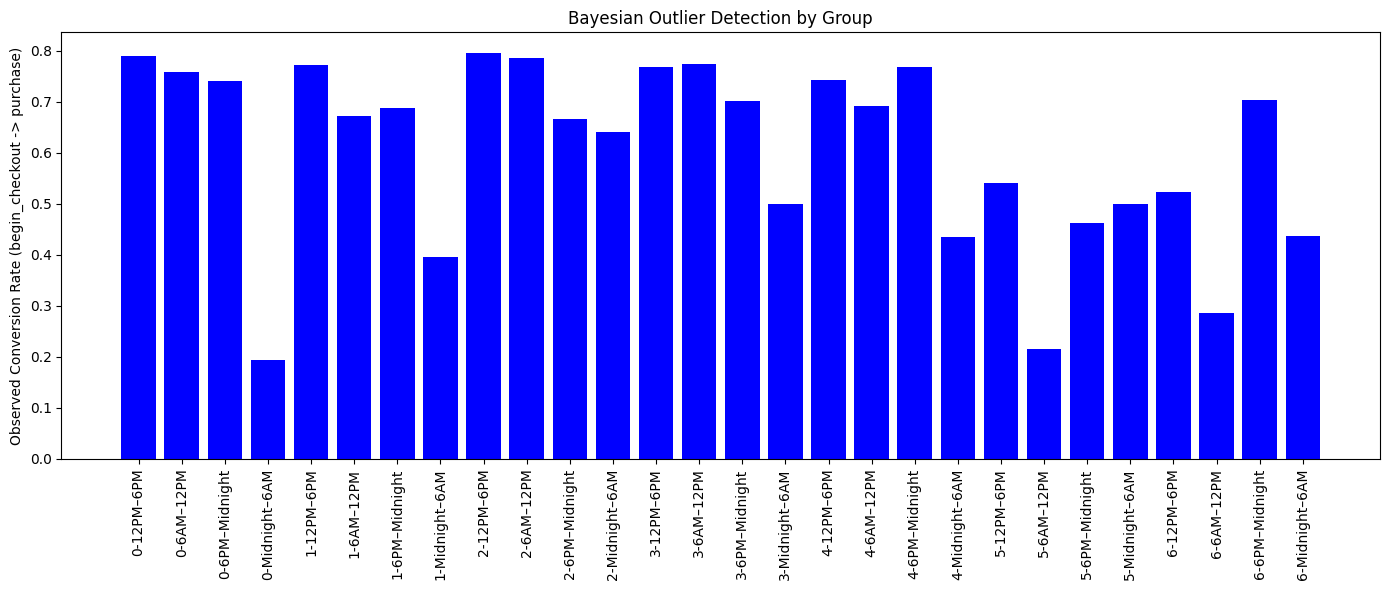

In [ ]:
#Bayesian Funnel Benchmark Model by hour and weekday
model_df_p = conversion_hbw.reset_index()[['hourbin_weekday','begin_checkout','purchase']].copy()
model_df_p.rename(columns={
    'hourbin_weekday': 'group',
    'begin_checkout': 'n_trials',
    'purchase': 'n_successes'
}, inplace=True)

# Prepare model input data
groups = model_df_p['group'].values               # Group names
n_groups = len(groups)                            # Number of groups
n_trials = model_df_p['n_trials'].values          # Total number of trials per group
n_successes = model_df_p['n_successes'].values    # Total number of successes per group

# Define Bayesian model
with pm.Model() as model:
    # Hyperpriors for the Beta distribution parameters (for all groups)
    alpha_hyper = pm.HalfNormal('alpha_hyper', sigma=10)
    beta_hyper = pm.HalfNormal('beta_hyper', sigma=10)

    # Conversion rate for each group (theta) with Beta distribution
    theta = pm.Beta('theta', alpha=alpha_hyper, beta=beta_hyper, shape=n_groups)

    # Observed data follows Binomial distribution
    obs = pm.Binomial('obs', n=n_trials, p=theta, observed=n_successes)

    # Posterior sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Summarize posterior estimates for theta
summary = az.summary(trace, var_names=['theta'], hdi_prob=0.95)
summary['group'] = groups
summary['observed_rate'] = n_successes / n_trials  # Empirical conversion rate per group

# Flag outliers where observed conversion rate falls outside 95% HDI
summary['flagged'] = ~summary.apply(
    lambda row: row['hdi_2.5%'] <= row['observed_rate'] <= row['hdi_97.5%'],
    axis=1
)

# Retain relevant summary columns
summary_df = summary[['group', 'observed_rate', 'mean', 'hdi_2.5%', 'hdi_97.5%', 'flagged']].copy()

# Print sorted summary with flagged anomalies first
print(summary_df.sort_values('flagged', ascending=False))

# Visualize: red bars indicate anomalies
plt.figure(figsize=(14, 6))
colors = summary_df['flagged'].map({True: 'red', False: 'blue'})
plt.bar(summary_df['group'], summary_df['observed_rate'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Observed Conversion Rate (begin_checkout → purchase)')
plt.title('Bayesian Outlier Detection by Group')
plt.tight_layout()
plt.show()


Output()

                           group  observed_rate   mean  hdi_2.5%  hdi_97.5%  \
theta[0]      corporate-(direct)       0.751692  0.752     0.736      0.769   
theta[1]         corporate-Other       0.761146  0.761     0.737      0.784   
theta[16]             web-google       0.840367  0.840     0.809      0.870   
theta[15]               web-bing       0.855721  0.852     0.803      0.896   
theta[14]          web-PRODUCTAD       0.750000  0.669     0.331      0.966   
theta[13]              web-Other       0.866667  0.853     0.753      0.944   
theta[12]           web-(direct)       0.814910  0.813     0.775      0.852   
theta[11]   notLoggedIn-hs_email       0.048266  0.049     0.038      0.060   
theta[10]     notLoggedIn-google       0.071694  0.072     0.068      0.075   
theta[9]        notLoggedIn-bing       0.073339  0.073     0.067      0.080   
theta[8]   notLoggedIn-PRODUCTAD       0.011719  0.013     0.005      0.021   
theta[7]       notLoggedIn-Other       0.092702  0.0

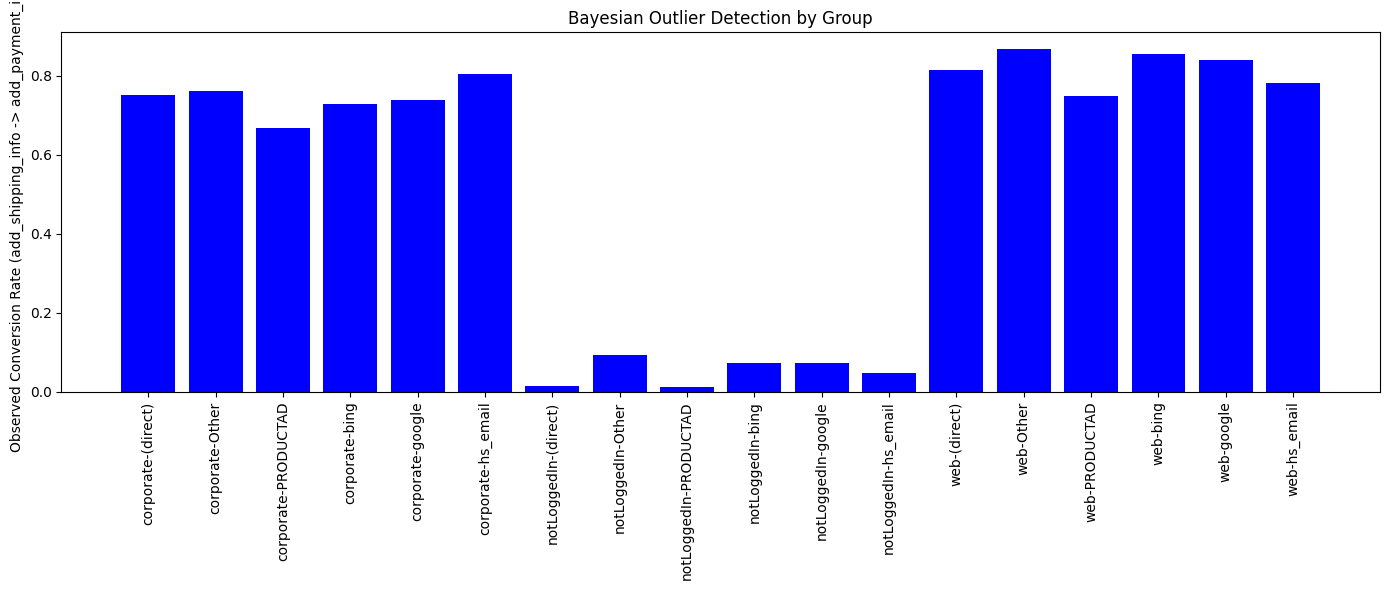

In [ ]:
#Bayesian Funnel Benchmark Model by customer_type and traffic source
model_df_tc_p = conversion[['customer_type', 'traffic_group', 'begin_checkout','purchase']].copy()
model_df_tc_p['group'] = model_df_tc['customer_type'] + '-' + model_df_tc['traffic_group']

model_df_tc_p = model_df_tc.rename(columns={
    'begin_checkout': 'n_trials',
    'purchase': 'n_successes'
})

# Prepare input data for the Bayesian model
groups = model_df_tc_p['group'].values               # Group identifiers
n_groups = len(groups)                               # Total number of groups
n_trials = model_df_tc_p['n_trials'].values          # Number of trials per group
n_successes = model_df_tc_p['n_successes'].values    # Number of successful conversions per group

# Define Bayesian hierarchical model
with pm.Model() as model:
    # Hyperpriors for Beta distribution parameters (shared across groups)
    alpha_hyper = pm.HalfNormal('alpha_hyper', sigma=10)
    beta_hyper = pm.HalfNormal('beta_hyper', sigma=10)

    # Conversion rate per group, modeled as a Beta distribution
    theta = pm.Beta('theta', alpha=alpha_hyper, beta=beta_hyper, shape=n_groups)

    # Likelihood: observed number of conversions follows a Binomial distribution
    obs = pm.Binomial('obs', n=n_trials, p=theta, observed=n_successes)

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Summarize the posterior distribution of theta for each group
summary = az.summary(trace, var_names=['theta'], hdi_prob=0.95)
summary['group'] = groups
summary['observed_rate'] = n_successes / n_trials  # Empirical conversion rate

# Flag as outlier if observed rate is outside the 95% HDI interval
summary['flagged'] = ~summary.apply(
    lambda row: row['hdi_2.5%'] <= row['observed_rate'] <= row['hdi_97.5%'],
    axis=1
)

# Select and arrange final output columns
summary_df = summary[['group', 'observed_rate', 'mean', 'hdi_2.5%', 'hdi_97.5%', 'flagged']].copy()

# Print groups sorted by flagged status (anomalies first)
print(summary_df.sort_values('flagged', ascending=False))

# Plot the observed rates, coloring anomalies in red
plt.figure(figsize=(14, 6))
colors = summary_df['flagged'].map({True: 'red', False: 'blue'})
plt.bar(summary_df['group'], summary_df['observed_rate'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Observed Conversion Rate (add_shipping_info → add_payment_info)')
plt.title('Bayesian Outlier Detection by Group')
plt.tight_layout()
plt.show()